In [1]:
import pandas as pd
import json
import re
import numpy as np
from scipy.stats import circstd

In [2]:
#### SANE DATA ####

In [3]:
# Load the filtered TCP packets from the legit JSON file
with open('training_legit_heading_simple.json', 'r') as json_file:
    datalegit = json.load(json_file)

In [4]:
# Filter and extract heading values from data
sample_headings = []
for packet in datalegit:
    if ('tcp' in packet['_source']['layers'] and
        packet['_source']['layers']['ip']['ip.src'] == '10.1.4.15' and
        'data' in packet['_source']['layers'] and
        'data.text' in packet['_source']['layers']['data'] and
        'heading' in packet['_source']['layers']['data']['data.text']):

        heading_value = float(packet['_source']['layers']['data']['data.text'].split('\r\n')[1])
        sample_headings.append(heading_value)

# Print the extracted heading values
print(sample_headings)

[12.3, 12.9, 13.2, 13.8, 14.2, 14.9, 15.3, 16.2, 16.7, 17.5, 18.1, 19.0, 19.4, 20.3, 20.8, 21.7, 22.2, 23.4, 23.8, 24.8, 25.3, 26.4, 26.9, 28.0, 28.5, 24.0, 29.8, 30.4, 31.6, 32.1, 33.3, 33.8, 35.1, 35.7, 36.7, 37.2, 38.2, 38.7, 39.6, 39.9, 40.7, 41.1, 41.7, 42.1, 42.8, 43.1, 43.8, 44.0, 44.6, 44.8, 45.4, 45.6, 45.8, 45.9, 46.1, 46.2, 46.1, 45.9, 45.7, 45.4, 45.3, 44.8, 44.5, 44.1, 43.8, 43.2, 42.9, 42.2, 41.9, 41.1, 40.7, 39.9, 39.5, 38.6, 38.1]


In [5]:
## START OF THE ANALYSIS ##

In [6]:
# Define the window size for calculating standard deviation
window_size = 5
min_anomaly_window = 3  # Minimum number of consecutive anomalies to trigger an alert

In [7]:
# Calculate the standard deviation for each window of size window_size
max_std_dev = 0.0
for i in range(len(sample_headings) - window_size + 1):
    window = sample_headings[i:i + window_size]
    std_dev = circstd(np.radians(sample_headings),  high=2*np.pi, low=0) 
    max_std_dev = max(max_std_dev, std_dev)

print(max_std_dev)

0.19316512139071237


In [8]:
# Set a threshold factor for anomaly detection
threshold_factor = 1.0

# Calculate the threshold based on the maximum standard deviation
threshold = threshold_factor * max_std_dev

# Print the calculated threshold
print("Threshold:", threshold)

Threshold: 0.19316512139071237


In [9]:
#### Data under-attack ####

In [10]:
# Load the second filtered TCP packets from the legit JSON file
#with open('another_heading_legit.json', 'r') as json_file:
#    data_attack = json.load(json_file)
    
# Load the filtered TCP packets from the under-attack JSON file
with open('training_attack_heading_simple.json', 'r') as json_file:
    data_attack = json.load(json_file)

In [11]:
# Filter and extract heading values from data
new_headings = []
for packet in data_attack:
    if ('tcp' in packet['_source']['layers'] and
        packet['_source']['layers']['ip']['ip.src'] == '10.1.4.15' and
        'data' in packet['_source']['layers'] and
        'data.text' in packet['_source']['layers']['data'] and
        'heading' in packet['_source']['layers']['data']['data.text']):

        heading_value = float(packet['_source']['layers']['data']['data.text'].split('\r\n')[1])
        new_headings.append(heading_value)

# Print the extracted heading values
print(new_headings)

[56.0, 80.0, 56.0, 80.0, 56.2, 80.0, 56.3, 80.0, 56.4, 80.0, 56.4, 80.0, 56.5, 80.0, 56.4, 80.0, 56.3, 80.0, 56.3, 80.0, 56.1, 80.0, 55.9, 80.0, 55.6, 80.0, 55.4, 80.0, 54.9, 80.0, 54.7, 80.0, 54.1, 80.0, 53.8, 80.0, 53.3, 80.0, 52.9, 80.0, 52.2, 80.0, 51.9, 80.0, 51.1, 80.0, 50.6, 80.0, 49.9, 80.0, 49.5, 80.0, 48.5, 80.0, 48.0, 80.0, 47.0, 80.0, 46.5, 80.0, 45.4, 80.0, 45.0, 80.0, 43.9, 80.0, 43.3, 80.0, 42.1, 80.0, 41.5, 80.0, 40.3, 80.0, 39.8, 80.0, 38.6, 80.0, 38.0, 80.0, 36.7, 80.0, 36.0, 80.0, 34.6, 80.0, 34.0, 80.0, 32.8, 80.0, 32.2, 80.0, 31.0, 80.0, 30.3, 80.0, 28.9, 80.0, 27.7, 80.0, 26.4, 80.0, 25.7, 80.0, 24.5, 80.0, 23.8, 80.0, 22.5, 80.0, 21.8, 80.0, 20.4, 80.0, 19.7, 80.0, 18.5, 80.0, 17.7, 80.0, 16.3, 80.0, 15.5, 80.0, 14.0, 80.0, 13.4, 80.0, 12.0, 80.0, 11.4, 80.0, 9.8, 80.0, 9.1, 80.0]


In [12]:
## DETECTION LOOP ## 

In [13]:
anomaly_count = 0
for heading in range(len(new_headings) - window_size + 1):
    window = new_headings[heading:heading + window_size]
    std_dev = circstd(np.radians(window),  high=6.283185307179586, low=0) 
    if std_dev > threshold:
        anomaly_count += 1
        if anomaly_count >= min_anomaly_window:
            print("Possible attack detected!")
            #print(f"Heading: {new_headings[heading]:.1f}")
            print("Anomaly window:", anomaly_count)
            break
    else:
        anomaly_count = 0

Possible attack detected!
Anomaly window: 3


In [14]:
## PLOT ## 

In [15]:
import matplotlib.pyplot as plt

# Both Dataset must have the same lenght
min_length = min(len(sample_headings), len(new_headings))
sample_headings = sample_headings[:min_length]
new_headings = new_headings[:min_length]

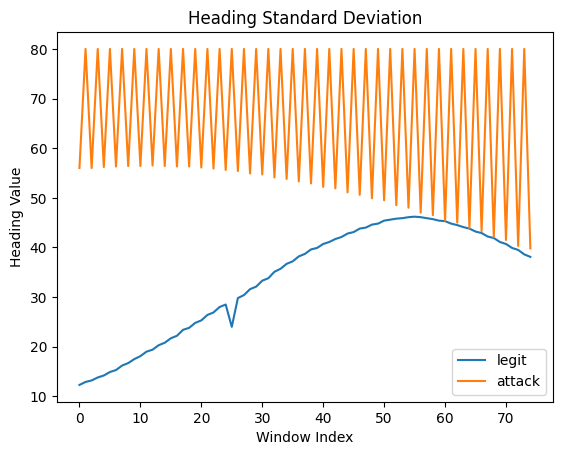

In [17]:
# Plot the heading values
import matplotlib.pyplot as plt
plt.plot(sample_headings, label='legit')
plt.plot(new_headings, label='attack')
plt.xlabel('Window Index')
plt.ylabel('Heading Value')
plt.title('Heading Standard Deviation')
plt.legend()
plt.show()

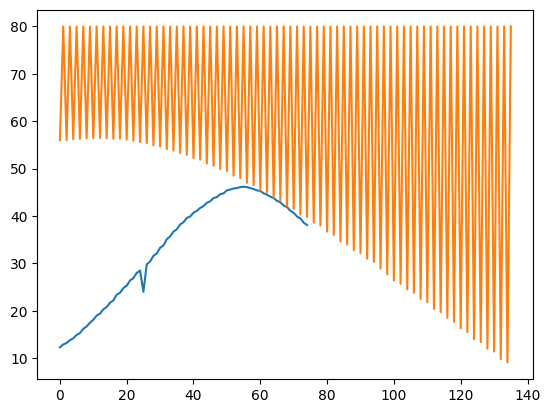

In [22]:
# Plot the same number of heading values
import matplotlib.pyplot as plt
plt.plot(sample_headings[:len(new_headings)])
plt.plot(new_headings)
plt.show()


In [20]:
#######  EVALUATION  #######

In [15]:
# Create overlap windows
benign_windows = [(sample_headings[i:i + window_size],0) for i in range(len(sample_headings) - window_size + 1)]

malicious_windows = [(new_headings[i:i + window_size],1) for i in range(len(new_headings) - window_size + 1)]

# Stampa le finestre
for window in malicious_windows:
    print(window)

([56.0, 80.0, 56.0, 80.0, 56.2], 1)
([80.0, 56.0, 80.0, 56.2, 80.0], 1)
([56.0, 80.0, 56.2, 80.0, 56.3], 1)
([80.0, 56.2, 80.0, 56.3, 80.0], 1)
([56.2, 80.0, 56.3, 80.0, 56.4], 1)
([80.0, 56.3, 80.0, 56.4, 80.0], 1)
([56.3, 80.0, 56.4, 80.0, 56.4], 1)
([80.0, 56.4, 80.0, 56.4, 80.0], 1)
([56.4, 80.0, 56.4, 80.0, 56.5], 1)
([80.0, 56.4, 80.0, 56.5, 80.0], 1)
([56.4, 80.0, 56.5, 80.0, 56.4], 1)
([80.0, 56.5, 80.0, 56.4, 80.0], 1)
([56.5, 80.0, 56.4, 80.0, 56.3], 1)
([80.0, 56.4, 80.0, 56.3, 80.0], 1)
([56.4, 80.0, 56.3, 80.0, 56.3], 1)
([80.0, 56.3, 80.0, 56.3, 80.0], 1)
([56.3, 80.0, 56.3, 80.0, 56.1], 1)
([80.0, 56.3, 80.0, 56.1, 80.0], 1)
([56.3, 80.0, 56.1, 80.0, 55.9], 1)
([80.0, 56.1, 80.0, 55.9, 80.0], 1)
([56.1, 80.0, 55.9, 80.0, 55.6], 1)
([80.0, 55.9, 80.0, 55.6, 80.0], 1)
([55.9, 80.0, 55.6, 80.0, 55.4], 1)
([80.0, 55.6, 80.0, 55.4, 80.0], 1)
([55.6, 80.0, 55.4, 80.0, 54.9], 1)
([80.0, 55.4, 80.0, 54.9, 80.0], 1)
([55.4, 80.0, 54.9, 80.0, 54.7], 1)
([80.0, 54.9, 80.0, 54.7, 80

In [16]:
import random
# Combine windows and labels into a single list
combined_windows = benign_windows + malicious_windows

# Print the result
for window, label in combined_windows:
    print("Window:", window)
    print("Label:", label)
    print()

Window: [12.3, 12.9, 13.2, 13.8, 14.2]
Label: 0

Window: [12.9, 13.2, 13.8, 14.2, 14.9]
Label: 0

Window: [13.2, 13.8, 14.2, 14.9, 15.3]
Label: 0

Window: [13.8, 14.2, 14.9, 15.3, 16.2]
Label: 0

Window: [14.2, 14.9, 15.3, 16.2, 16.7]
Label: 0

Window: [14.9, 15.3, 16.2, 16.7, 17.5]
Label: 0

Window: [15.3, 16.2, 16.7, 17.5, 18.1]
Label: 0

Window: [16.2, 16.7, 17.5, 18.1, 19.0]
Label: 0

Window: [16.7, 17.5, 18.1, 19.0, 19.4]
Label: 0

Window: [17.5, 18.1, 19.0, 19.4, 20.3]
Label: 0

Window: [18.1, 19.0, 19.4, 20.3, 20.8]
Label: 0

Window: [19.0, 19.4, 20.3, 20.8, 21.7]
Label: 0

Window: [19.4, 20.3, 20.8, 21.7, 22.2]
Label: 0

Window: [20.3, 20.8, 21.7, 22.2, 23.4]
Label: 0

Window: [20.8, 21.7, 22.2, 23.4, 23.8]
Label: 0

Window: [21.7, 22.2, 23.4, 23.8, 24.8]
Label: 0

Window: [22.2, 23.4, 23.8, 24.8, 25.3]
Label: 0

Window: [23.4, 23.8, 24.8, 25.3, 26.4]
Label: 0

Window: [23.8, 24.8, 25.3, 26.4, 26.9]
Label: 0

Window: [24.8, 25.3, 26.4, 26.9, 28.0]
Label: 0

Window: [25.3, 26.4,

In [17]:
result_labels=[]
print(len(combined_windows))


for heading in range(len(combined_windows)):
    windows_subset = combined_windows[heading:heading + window_size]
    window_data = [window[0] for window in windows_subset]  # Extract window data from each tuple
    std_dev = circstd(np.radians(window_data[0]), high=2*np.pi, low=0)
    if std_dev >= threshold:
        result_labels.append(1)
        print([window_data[0], 1])
        print("window_data", [window_data[0], 1])
        print("std_dev:", std_dev)
        print("threshold:", threshold)
    else:
        result_labels.append(0)
        print([window_data[0], 0])
        print("window_data", [window_data[0], 1])
        print("std_dev:", std_dev)
        print("threshold:", threshold)

# Print the evaluation results
print(result_labels)
print(len(result_labels))


203
[[12.3, 12.9, 13.2, 13.8, 14.2], 0]
window_data [[12.3, 12.9, 13.2, 13.8, 14.2], 1]
std_dev: 0.011650727389152267
threshold: 0.19316512139071237
[[12.9, 13.2, 13.8, 14.2, 14.9], 0]
window_data [[12.9, 13.2, 13.8, 14.2, 14.9], 1]
std_dev: 0.01243977961618561
threshold: 0.19316512139071237
[[13.2, 13.8, 14.2, 14.9, 15.3], 0]
window_data [[13.2, 13.8, 14.2, 14.9, 15.3], 1]
std_dev: 0.013126116909394034
threshold: 0.19316512139071237
[[13.8, 14.2, 14.9, 15.3, 16.2], 0]
window_data [[13.8, 14.2, 14.9, 15.3, 16.2], 1]
std_dev: 0.014702415587881055
threshold: 0.19316512139071237
[[14.2, 14.9, 15.3, 16.2, 16.7], 0]
window_data [[14.2, 14.9, 15.3, 16.2, 16.7], 1]
std_dev: 0.015634314270322785
threshold: 0.19316512139071237
[[14.9, 15.3, 16.2, 16.7, 17.5], 0]
window_data [[14.9, 15.3, 16.2, 16.7, 17.5], 1]
std_dev: 0.01638776489831426
threshold: 0.19316512139071237
[[15.3, 16.2, 16.7, 17.5, 18.1], 0]
window_data [[15.3, 16.2, 16.7, 17.5, 18.1], 1]
std_dev: 0.017086661887685775
threshold: 0.1

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Extract labels from the list of tuples combined_windows
true_labels = [label for _, label in combined_windows]

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, result_labels)
precision = precision_score(true_labels, result_labels)
recall = recall_score(true_labels, result_labels)
f1 = f1_score(true_labels, result_labels)

# print results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0
